In [1]:
%load_ext rpy2.ipython
import pandas as pd
import configparser
from psycopg2 import connect
import psycopg2.sql as pg
import pandas.io.sql as pandasql
from sqlalchemy import create_engine
import io
import datetime 
import numpy 
from rpy2.robjects.packages import importr
utils = importr('utils')
utils.install_packages('forecast')

CONFIG = configparser.ConfigParser()
CONFIG.read(r'C:\Users\alouis2\Documents\Python Scripts\db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)
pd.options.display.mpl_style = 'default'


C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2862: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


## The Forecast Function
***

`forecast` computes a one day forecast given a day, intersection, direction, and intersection leg. The function works through R's auto-arima fitting, and then forecasts the next 56 points (i.e. 4 * 14). A plot is returned of the forecast. The forecast has 80% and 95% percentile upper and lower bounds. These bounds will be used to detect anomalous 15 minute counts. A few examples of the function can be seen below. 

In [97]:
def grab(day, intersection, direction, int_leg):
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    for i in days:
        if i == day:
            day = days.index(i) + 1
    strSQL = '''WITH ts AS (SELECT datetime_bin, sum(volume) as volume
                FROM miovision.volumes_15min
            INNER JOIN miovision.intersections USING (intersection_uid)
            WHERE classification_uid in (1,4,5)
            AND intersection_name = '%s'
            AND (leg = '%s' AND dir = '%s')
            AND extract(dow from datetime_bin) in (%s)
            and extract('hour' from datetime_bin) >= 6
            and extract('hour' from datetime_bin) < 20
            GROUP BY datetime_bin
            ORDER BY datetime_bin),
            
            proper AS (SELECT datetime_bin::date, COUNT(volume)
            from ts
            group by datetime_bin::date
            having count(volume) = 56)
            
            select * from ts
            where datetime_bin::date in (select datetime_bin from proper)''' % (intersection, int_leg, direction, day)
    return pandasql.read_sql(pg.SQL(strSQL), con)
    

def forecast(day, intersection, direction, int_leg):
    data = grab(day, intersection, direction, int_leg)
    % R  library('forecast')
    %R -i data
    % R x <- ts(data$volume, frequency = 56)
    % R fit <- auto.arima(x) # automated arima modelling of data
    % R nextday <- data.frame(forecast(fit, h = 56))
    %R -o nextday
    return pd.DataFrame(nextday)

#### **Thursday Front and Spadina Forecast (Eastbound, East leg)**

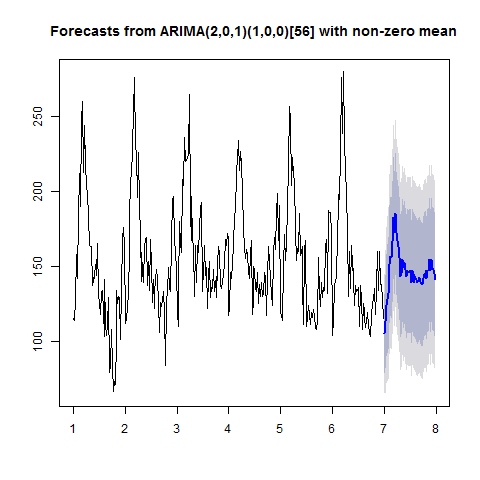

In [3]:
forecast("Thursday", "Front / Spadina", "EB", "E")

#### **Monday Queen and Jarvis Forecast (Westbound, East leg)**

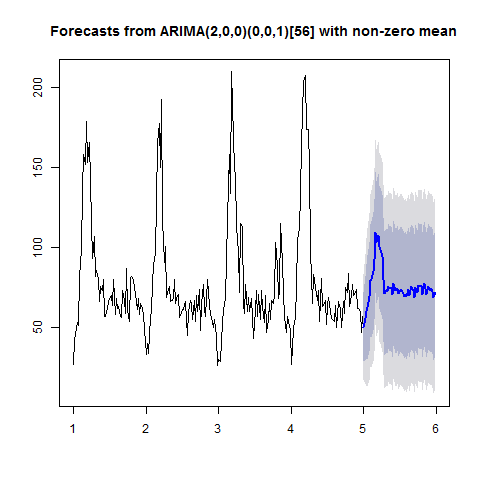

In [4]:
forecast("Monday", "Queen / Jarvis", "WB", "E")

In [99]:
upper95 = forecast("Friday", "Adelaide / Spadina", "EB", "E")['Hi.95']
lower95 = forecast("Friday", "Adelaide / Spadina", "EB", "E")['Lo.95']
upper80 = forecast("Friday", "Adelaide / Spadina", "EB", "E")['Hi.80']
lower80 = forecast("Friday", "Adelaide / Spadina", "EB", "E")['Lo.80']


In [121]:
pd.DataFrame(upper95).reset_index()['Hi.95']

0     254.152422
1     249.991175
2     276.400892
3     276.632913
4     283.748222
5     289.667915
6     301.346886
7     304.323907
8     320.927347
9     320.521713
10    297.683010
11    319.029149
12    310.597235
13    311.447609
14    290.373672
15    286.785026
16    303.137809
17    296.582333
18    292.838795
19    277.485292
20    281.624587
21    276.574898
22    278.953234
23    295.707327
24    279.789081
25    294.198004
26    279.200685
27    280.709643
28    273.318068
29    270.823650
30    287.478567
31    288.800305
32    273.803542
33    264.228003
34    278.992379
35    278.689564
36    269.824206
37    280.764445
38    288.281161
39    290.069770
40    285.518701
41    295.180349
42    299.722229
43    310.909151
44    302.030506
45    287.454990
46    289.598642
47    295.089885
48    288.001677
49    279.140672
50    286.352166
51    304.345445
52    295.014786
53    305.519967
54    295.831223
55    299.497138
Name: Hi.95, dtype: float64